# Wavelet image (de)compression

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data

In [3]:
# Load image
original = pywt.data.camera()

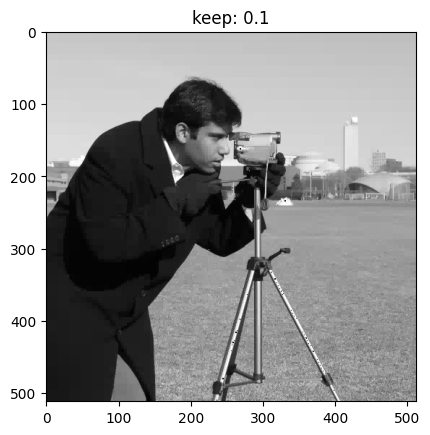

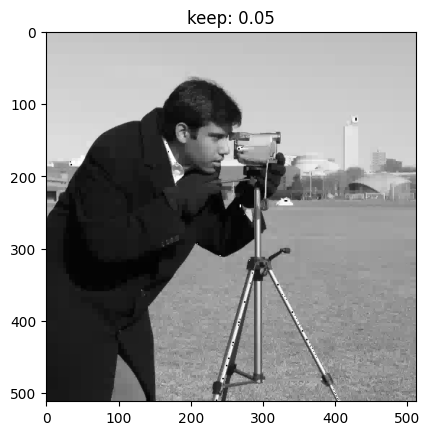

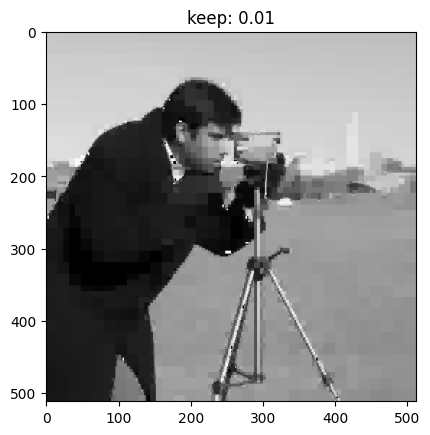

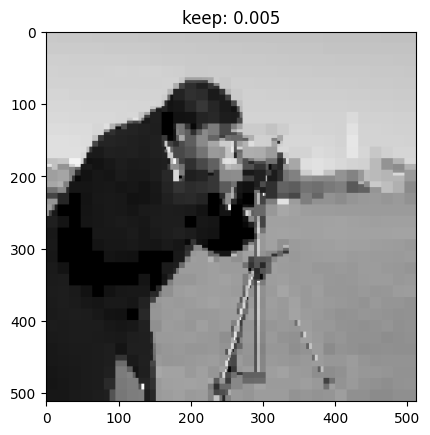

In [4]:
# B = np.mean(image, -1) # convert to grayscale

n = 4
wavelet = 'db1'

coeffs2 = pywt.wavedec2(original, wavelet=wavelet, level=n)

coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs2)
Csort = np.sort(np.abs(coeff_arr.reshape(-1)))

for keep in (.1, .05, .01, .005):
    thresh = Csort[int(np.floor((1-keep)*len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind
    coeffs_filt = pywt.array_to_coeffs(Cfilt, coeff_slices, output_format='wavedec2')

    Arecon = pywt.waverec2(coeffs_filt, wavelet=wavelet)

    plt.figure()
    plt.imshow(Arecon.astype('uint8'), cmap=plt.cm.gray)
    plt.imsave(f'../data/keep_{keep}.png', Arecon.astype('uint8'), cmap=plt.cm.gray)
    plt.title(f'keep: {keep}')

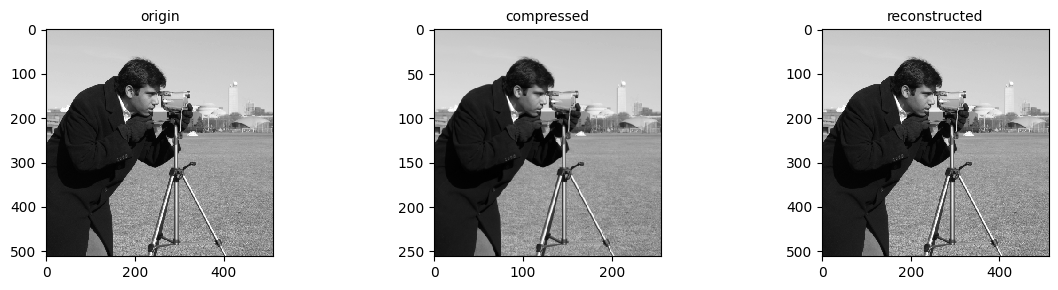

In [48]:
wavelet = 'bior1.3'
# wavelet = 'db1'
coeffs2 = pywt.dwt2(original, wavelet)
LL, _ = coeffs2

reconstructed = pywt.idwt2(coeffs2, wavelet)

titles = ['origin', 'compressed', 'reconstructed']

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([original, LL, reconstructed]):
    ax = fig.add_subplot(1, 3, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    plt.imsave(f'../data/{titles[i]}.png', a, cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)

fig.tight_layout()
plt.show()

From left to right: 260 vs 68 vs 260 kb

In [5]:
from keras import layers, Input, Model
from keras.datasets import mnist
from keras.optimizers import Adam
from keras.metrics import Mean, MAE
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob

In [6]:
vqvae_model = load_model('../models/lossless_compressor_model_v1')

Metal device set to: Apple M1 Pro


2023-02-17 13:37:27.442516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-17 13:37:27.442675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
encoder = vqvae_model.get_layer("encoder")
quantizer = vqvae_model.get_layer("vector_quantizer")
decoder = vqvae_model.get_layer('decoder')

In [8]:
def get_code_indices(flattened_inputs, embeddings):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [27]:
original.shape

(512, 512)

In [53]:
expanded_dim = np.expand_dims(original, axis=-1)

In [54]:
expanded_dim.shape

(512, 512, 1)

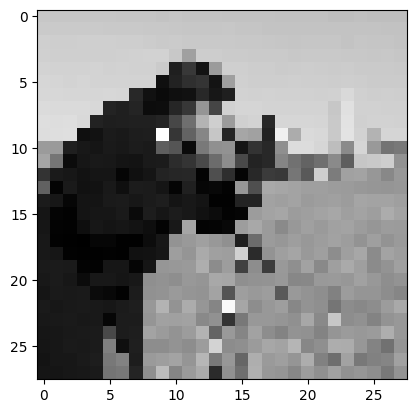

In [61]:
import cv2

resized_data = cv2.resize(expanded_dim, (28,28), interpolation= cv2.INTER_LINEAR)

plt.imshow(resized_data, cmap=plt.cm.gray)

In [63]:
resized_data = (resized_data / 255.0) - .5
resized_data = np.expand_dims(resized_data, axis=-1)

resized_data.shape

(28, 28, 1)

In [66]:
test_images = resized_data

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = get_code_indices(flat_enc_outputs, quantizer.embeddings)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

2023-02-17 14:12:53.698236: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-17 14:12:53.747880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 504ms/step


In [68]:
encoded_outputs.shape

(28, 7, 1, 16)

In [67]:
quantized_latents = quantizer(encoded_outputs)
reconstructed_img = decoder.predict(quantized_latents)

ValueError: Exception encountered when calling layer "vector_quantizer" "                 f"(type VectorQuantizer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * <tf.Tensor 'x:0' shape=(28, 7, 1, 16) dtype=float32>
  Keyword arguments: {}

 Expected these arguments to match one of the following 1 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, 7, 7, 16), dtype=tf.float32, name='x')
  Keyword arguments: {}

Call arguments received by layer "vector_quantizer" "                 f"(type VectorQuantizer):
  • args=('tf.Tensor(shape=(28, 7, 1, 16), dtype=float32)',)
  • kwargs=<class 'inspect._empty'>